In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import itertools
import scipy.sparse as sp

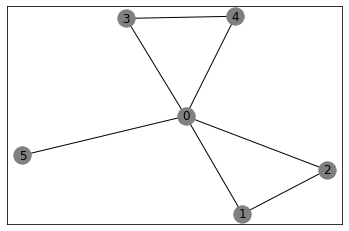

In [2]:

import networkx as nx
import matplotlib.pyplot as plt
   

class GraphVisualization:

    def __init__(self):


        self.visual = []

    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)


    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G,node_color='grey')
        plt.show()


G = GraphVisualization()
G.addEdge(0, 1)
G.addEdge(0, 2)
G.addEdge(1, 2)
G.addEdge(0, 3)
G.addEdge(0, 4)
G.addEdge(3, 4)
G.addEdge(0, 5)

G.visualize()


In [3]:
import dgl
import numpy as np

g = dgl.graph(([0, 0, 1, 0, 0, 3, 0], [1, 2, 2, 3, 4, 4, 5]), num_nodes=6)

#g = dgl.graph(([0, 0, 1, 0, 0, 3, 0], [1, 2, 2, 3, 4, 4, 5]))

print(g.ndata)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
{}


In [6]:
g.ndata['a'] = torch.randn(6, 3)

#g.edata['b'] = torch.randn(7, 4)

g.ndata['y'] = torch.randn(6, 5, 4)

# print("Node Data: ",g.ndata)
# print("Edge Data: ",g.edata)
print(g)
print(g.nodes())


Graph(num_nodes=6, num_edges=7,
      ndata_schemes={'a': Scheme(shape=(3,), dtype=torch.float32), 'y': Scheme(shape=(5, 4), dtype=torch.float32)}
      edata_schemes={})
tensor([0, 1, 2, 3, 4, 5])


In [7]:
print(g.num_nodes())
print(g.num_edges())

print(g.out_degrees(0))
print(g.in_degrees(0))

6
7
5
0


In [8]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
features = g.ndata['feat']
print('Features',features)
print('Features.shape',features.shape)
labels = g.ndata['label']
print('Labels',labels)
train_mask = g.ndata['train_mask']
print('Train Mask',train_mask)
print('len(Train Mask)',len(train_mask))

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Features tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Features.shape torch.Size([2708, 1433])
Labels tensor([3, 4, 4,  ..., 3, 3, 3])
Train Mask tensor([ True,  True,  True,  ..., False, False, False])
len(Train Mask) 2708


In [9]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
#         print("layer 1: ", h)
#         print("layer 1 shape: ", h.shape)
        h = F.relu(h)
#         print("Relu: ", h)
        h = self.conv2(g, h)
#         print("layer 2: ", h)
#         print("layer 2 shape: ", h.shape)
        
        return h

# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [11]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    
    #for e in range(100):
    # Forward
    logits = model(g, features)
    print('Logits.shape', logits.shape)
    print('Logits', logits)

    # Compute prediction
    pred = logits.argmax(1)
    print('Pred', pred)
    print('len(Pred)', len(pred))

    # Compute loss
    # Note that you should only compute the losses of the nodes in the training set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
#         print('pred[train_mast] == labels[train_mask]',(pred[train_mask]==labels[train_mask]).float().mean())
#         print('len(pred[train_mast])',len(pred[train_mask]))
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Save the best validation accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#     if e % 5 == 0:
#         print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
#             e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

            
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

Logits.shape torch.Size([2708, 7])
Logits tensor([[ 0.0046, -0.0046, -0.0040,  ...,  0.0020,  0.0003,  0.0043],
        [ 0.0010, -0.0015, -0.0030,  ...,  0.0027,  0.0008,  0.0016],
        [ 0.0032, -0.0041, -0.0023,  ...,  0.0028, -0.0014,  0.0036],
        ...,
        [ 0.0107, -0.0036, -0.0016,  ...,  0.0024, -0.0029,  0.0066],
        [ 0.0034, -0.0026, -0.0042,  ..., -0.0028, -0.0040,  0.0012],
        [ 0.0022, -0.0023, -0.0032,  ..., -0.0016, -0.0017,  0.0010]],
       grad_fn=<AddBackward0>)
Pred tensor([3, 4, 6,  ..., 0, 0, 3])
len(Pred) 2708


In [ ]:
# Adding Edge Weights to graph

In [12]:
from dgl.nn import EdgeWeightNorm, GraphConv

In [13]:
g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
print("Before Self loop ",g.edges())
g = dgl.add_self_loop(g)
print("After Self loop ",g.edges())
feat = th.ones(6, 10)
#print("features ",feat)
print("Num of edges ",g.num_edges())
edge_weight = th.tensor([0.5, 0.6, 0.4, 0.7, 0.9, 0.1, 1, 1, 1, 1, 1, 1])
print("Length of edge_weight ",len(edge_weight))
# norm = EdgeWeightNorm(norm='both')
# norm_edge_weight = norm(g, edge_weight)
#print("norm_edge_weight ",norm_edge_weight)
conv = GraphConv(10, 2, norm='none', weight=True, bias=True)
res = conv(g, feat, edge_weight=edge_weight)
print(res)

Before Self loop  (tensor([0, 1, 2, 3, 2, 5]), tensor([1, 2, 3, 4, 0, 3]))
After Self loop  (tensor([0, 1, 2, 3, 2, 5, 0, 1, 2, 3, 4, 5]), tensor([1, 2, 3, 4, 0, 3, 0, 1, 2, 3, 4, 5]))
Num of edges  12
Length of edge_weight  12
tensor([[2.3041, 1.4520],
        [1.8190, 1.1463],
        [1.9403, 1.2227],
        [1.8190, 1.1463],
        [2.0615, 1.2992],
        [1.2127, 0.7642]], grad_fn=<AddBackward0>)


In [14]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [32]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
print("no.of edges ",g.number_of_edges())
print("eids ",eids)
print("eids ",len(eids))
eids = np.random.permutation(eids)
print("eids ",eids)
print("eids ",len(eids))
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
#print("adj: ",adj)
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
#print("adj_neg: ",adj_neg)
neg_u, neg_v = np.where(adj_neg != 0)
print("neg_u: ",neg_u, "neg_v: ", neg_v)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

no.of edges  10556
eids  [    0     1     2 ... 10553 10554 10555]
eids  10556
eids  [6427 3197 4862 ... 4732 3591 5704]
eids  10556
neg_u:  [   0    0    0 ... 2707 2707 2707] neg_v:  [   1    2    3 ... 2703 2704 2705]


In [16]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [17]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
#         print("layer 1: ", h)
#         print("layer 1 shape: ", h.shape)
        h = F.relu(h)
        h = self.conv2(g, h)
#         print("layer 2: ", h)
#         print("layer 2 shape: ", h.shape)
        return h

In [18]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
print("Train Pos Graph: ", train_pos_g)
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())
print("Train Neg Graph: ", train_neg_g)


test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
print("Test Pos Graph: ", test_pos_g)
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())
print("Test Neg Graph: ", test_neg_g)

Train Pos Graph:  Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={}
      edata_schemes={})
Train Neg Graph:  Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={}
      edata_schemes={})
Test Pos Graph:  Graph(num_nodes=2708, num_edges=1055,
      ndata_schemes={}
      edata_schemes={})
Test Neg Graph:  Graph(num_nodes=2708, num_edges=1055,
      ndata_schemes={}
      edata_schemes={})


In [19]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [20]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [21]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [22]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []

#for e in range(100):
# forward
h = model(train_g, train_g.ndata['feat'])
print("h: ", h)
pos_score = pred(train_pos_g, h)
print("pos_score: ", pos_score)
neg_score = pred(train_neg_g, h)
print("neg_score: ", neg_score)
loss = compute_loss(pos_score, neg_score)

# backward
optimizer.zero_grad()
loss.backward()
optimizer.step()

# if e % 5 == 0:
#     print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))


# Thumbnail Courtesy: Link Prediction with Neo4j, Mark Needham
# sphinx_gallery_thumbnail_path = '_static/blitz_4_link_predict.png'

h:  tensor([[-0.0250,  0.0098,  0.0387,  ..., -0.0058,  0.0238,  0.0156],
        [-0.0212,  0.0154,  0.0192,  ..., -0.0197,  0.0494, -0.0374],
        [-0.0310,  0.0049,  0.0393,  ..., -0.0118, -0.0049, -0.0139],
        ...,
        [ 0.0242, -0.0044, -0.0237,  ..., -0.0847,  0.0238,  0.0027],
        [-0.0281,  0.0359,  0.0130,  ..., -0.0218,  0.0167,  0.0027],
        [-0.0048,  0.0167,  0.0175,  ..., -0.0224,  0.0007, -0.0290]],
       grad_fn=<AddBackward0>)
pos_score:  tensor([0.0024, 0.0003, 0.0007,  ..., 0.0063, 0.0034, 0.0027],
       grad_fn=<SelectBackward>)
neg_score:  tensor([0.0028, 0.0037, 0.0022,  ..., 0.0005, 0.0022, 0.0019],
       grad_fn=<SelectBackward>)
AUC 0.5537683340446081


In [61]:
import dgl.data
import torch

# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
dataset = dgl.data.GINDataset('PROTEINS', self_loop=True)
print(len(dataset))

1113


In [62]:
print('Node feature dimensionality:', dataset.dim_nfeats)
print('Number of graph categories:', dataset.gclasses)

Node feature dimensionality: 3
Number of graph categories: 2


In [63]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
print("num_examples ",num_examples)
num_train = int(num_examples * 0.8)
print("num_train ",num_train)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
#print("torch.arange(num_train) ",torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))
#print("torch.arange(num_train, num_examples) ",torch.arange(num_train, num_examples))

print("torch.arange(num_train) ")
for i in range(5):
    print(torch.arange(num_train)[i])
    
count = 0
print("After Shuffling train_sampler")
for i in train_sampler:
    print(i)
    count += 1
    if count > 5:
        break
    
    
train_dataloader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=5, drop_last=False)

num_examples  1113
num_train  890
torch.arange(num_train) 
tensor(0)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
After Shuffling train_sampler
tensor(130)
tensor(659)
tensor(129)
tensor(87)
tensor(869)
tensor(867)


In [64]:
# it = iter(train_dataloader)
# batch = next(it)
# print(len(batch[0].ndata['attr']))

In [65]:
# batched_graph, labels = batch
# print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
# print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())


# graphs = dgl.unbatch(batched_graph)
# print('The original graphs in the minibatch:')
# print(graphs)

In [66]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        #print("Dim of Input Features ", in_feats)

    def forward(self, g, in_feat):
        #print("Input Features ",in_feat)
        #print("Length of Input Features ", len(in_feat))
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        #print("g.ndata['h'] ", g.ndata['h'])
        #print("Length of g.ndata['h'] ", len(g.ndata['h']))
        #print("Mean of Nodes ", dgl.mean_nodes(g, 'h'))
        return dgl.mean_nodes(g, 'h')

In [67]:
# Create the model with given dimensions
print("Num of Classes ", dataset.gclasses)
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        #print("labels ",labels)
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        #print("Prediction ",pred)
        
        #print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())

        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata['attr'].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print('Test accuracy:', num_correct / num_tests)

Num of Classes  2
Test accuracy: 0.22869955156950672


In [52]:
import urllib.request
import pandas as pd
urllib.request.urlretrieve('https://data.dgl.ai/tutorial/dataset/members.csv', './members.csv')
urllib.request.urlretrieve('https://data.dgl.ai/tutorial/dataset/interactions.csv', './interactions.csv')

members = pd.read_csv('./members.csv',index_col = 0)
print(members.head())

interactions = pd.read_csv('./interactions.csv',index_col = 0)
print("\n",interactions.head())

      Club  Age
Id             
0   Mr. Hi   44
1   Mr. Hi   37
2   Mr. Hi   37
3   Mr. Hi   40
4   Mr. Hi   30

      Dst    Weight
Src               
0      1  0.043591
0      2  0.282119
0      3  0.370293
0      4  0.730570
0      5  0.821187


In [51]:
from dgl.data import DGLDataset
import os

class KarateClubDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='karate_club')

    def process(self):
        nodes_data = pd.read_csv('./members.csv')
        edges_data = pd.read_csv('./interactions.csv')
        node_features = torch.from_numpy(nodes_data['Age'].to_numpy())
        node_labels = torch.from_numpy(nodes_data['Club'].astype('category').cat.codes.to_numpy())
        edge_features = torch.from_numpy(edges_data['Weight'].to_numpy())
        edges_src = torch.from_numpy(edges_data['Src'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['Dst'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        self.graph.edata['weight'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = KarateClubDataset()
graph = dataset[0]

print(graph)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  if sys.path[0] == '':
